# Analysis of StackOverflow Survey. Part I

In this notebook, we upload the data, present the questions to be investigated and explore some of the features of the data. We also perform a few pre-processing steps.

## Import packages and libraries

In [1]:
# general packages and libraries
import os
import sys
from collections import defaultdict
import importlib

In [2]:
# data manipulation packages
import numpy as np
import pandas as pd

In [3]:
# data visualizations packages
import matplotlib.pyplot as plt
# to render plots in the notebook
%matplotlib inline

import seaborn as sns
# set a theme for seaborn
sns.set_theme()

In [4]:
# import local module containing the neccessary functions
import utils_functions as uf

# forces the interpreter to re-load the module
importlib.reload(uf);

# create a path string
mypath = os.getcwd()

## Ask Questions

The well known questions and answers website Stack Overflow has been conducted annual surveys for a decade now.  These are the largest and the most comprehensive surveys of coders ever conducted. The anonymized results of the surveys are publicly available for analysis at [Stack Overflow Anual Developer Survey](https://insights.stackoverflow.com/survey).

The 2020 Stack Overflow Survey was conducted in February 2020, just before the COVID-19 pandemic affected the entire world. The survey consists of 60 questions distributed over six sections:

1. Basic Information
2. Education, Work, Career
3. Technology and Tech Culture
4. Stack Overflow Usage + Community
5. Demographic Information
6. Survey Opinion and Final Questions

The survey had 64461 (almost 65k) responses from 184 countries and regions.

I am interested in learning more about those developers who work with big data, such as data scientists, machine learning engineers, data and business analysts and data engineers. I call them data coders for short. In this analysis I will explore the following questions:

1. Do data coders have more formal educational background than the other coders? 
2. How does the salary of data coders compare with the salary of the other coders? 
3. Predict the job satisfaction of a data coder and determine the key factors affecting it.

## Gather Data and Check the Uploads

There are two csv files:
 - `results_public.csv` contains the survey results;
 - `results_schema.csv` contains the list of columns in the first file, together with their associated questions. 

In [6]:
# upload the datafiles as pandas dataframes
df = pd.read_csv(mypath+'/data/survey20_results_public.csv', index_col=[0])
dfs = pd.read_csv(mypath+'/data/survey20_results_schema.csv', index_col=[0])

In [7]:
# option to display the full text of the string columns
pd.set_option('display.max_colwidth', None)

In [8]:
# peek at the survey file
df.head(2)

,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,CurrencySymbol,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
Respondent,,,,,,,,,,,,,,,,,,,,,
1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,EUR,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or software engineering",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,GBP,...,NaN,NaN,NaN,"Computer science, computer engineering, or software engineering",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4


In [9]:
# peek at the description file
dfs.head()

,QuestionText
Column,
Respondent,Randomized respondent ID number (not in order of survey response time)
MainBranch,"Which of the following options best describes you today? Here, by ""developer"" we mean ""someone who writes code."""
Hobbyist,Do you code as a hobby?
Age,"What is your age (in years)? If you prefer not to answer, you may leave this question blank."
Age1stCode,"At what age did you write your first line of code or program? (e.g., webpage, Hello World, Scratch project)"


### Generate a profiling report 
The `pandas_profiling` library builds a profile report of the data. It summarizes all the important information regarding the data, including flags for missing data and high cardinality data. I will use the minimal mode that disables expensive computations (such as correlations and dynamic binning) to avoid 'maximum allowed size' error. The results will be saved in an .html file.

In [68]:
# run this once to generate the report and save it as html file

# import pandas_profiling
# profile = pandas_profiling.ProfileReport(df, minimal=True)
# profile.to_file(output_file="data_report.html")

## Investigate the Data

In [10]:
# get the shape of the data
df.shape

(64461, 60)

In [11]:
# general data information including the non-null values
df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64461 entries, 1 to 65112
Data columns (total 60 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   MainBranch                    64162 non-null  object 
 1   Hobbyist                      64416 non-null  object 
 2   Age                           45446 non-null  float64
 3   Age1stCode                    57900 non-null  object 
 4   CompFreq                      40069 non-null  object 
 5   CompTotal                     34826 non-null  float64
 6   ConvertedComp                 34756 non-null  float64
 7   Country                       64072 non-null  object 
 8   CurrencyDesc                  45472 non-null  object 
 9   CurrencySymbol                45472 non-null  object 
 10  DatabaseDesireNextYear        44070 non-null  object 
 11  DatabaseWorkedWith            49537 non-null  object 
 12  DevType                       49370 non-null  object 
 13  E

In [12]:
# get the percentages of missing entries in each column
df_null_perc = df.isnull().mean().round(2)
# sort in decreasing order of percentage of missing values
df_null_perc.sort_values(ascending=False).head()

CompTotal                 0.46
ConvertedComp             0.46
NEWPurchaseResearch       0.42
PurchaseWhat              0.39
WebframeDesireNextYear    0.38
dtype: float64

In [13]:
# sort in increasing order of percentage of missing values
df_null_perc.sort_values().head()

MainBranch    0.00
Hobbyist      0.00
Employment    0.01
Country       0.01
NEWSOSites    0.10
dtype: float64

#### Observations on the missing values:
- the columns with most missing values are 'ConvertedComp' and 'CompTotal';
- about a third of the columns are missing more than $30 \%$ of data;
- there are several columns with no missing data, 'Country' and 'Employment' among them.

In [14]:
# look at the descriptive statistics for the numerical data
df.describe().round(2) 

,Age,CompTotal,ConvertedComp,WorkWeekHrs
count,45446.00,3.482600e+04,34756.00,41151.00
mean,30.83,3.190464e+242,103756.05,40.78
std,9.59,inf,226885.30,17.82
min,1.00,0.000000e+00,0.00,1.00
25%,24.00,2.000000e+04,24648.00,40.00
50%,29.00,6.300000e+04,54049.00,40.00
75%,35.00,1.250000e+05,95000.00,44.00
max,279.00,1.111111e+247,2000000.00,475.00


#### Observations on the numerical data:
- most missing values in `ConvertedComp`, 'CompTotal', almost half of the values are missing;
- more than 30% values are missing in the `WorkWeekHours`;
- there are outliers in the numerical columns, as we can see from min/max values.

## Specific Information About the Data

### Distribution by country

In [15]:
# the number of countries involved
len(df.Country.unique())

184

In [16]:
# distribution of respondents per country
country_counts = df.Country.value_counts()
country_counts.head()

United States     12469
India              8403
United Kingdom     3896
Germany            3890
Canada             2191
Name: Country, dtype: int64

In [17]:
# distribution of respondents on countries using percentages
df.Country.value_counts(normalize=True) * 100

United States                         19.460919
India                                 13.114933
United Kingdom                         6.080659
Germany                                6.071295
Canada                                 3.419590
                                        ...    
Nauru                                  0.001561
Marshall Islands                       0.001561
Micronesia, Federated States of...     0.001561
Gabon                                  0.001561
Saint Lucia                            0.001561
Name: Country, Length: 183, dtype: float64

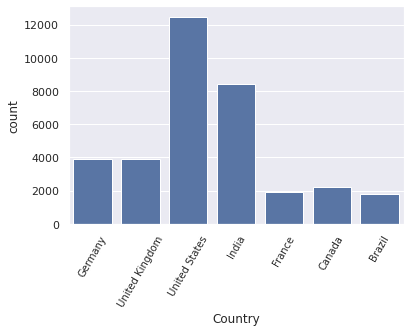

In [18]:
# the most represented countries, with more than 2000 respondents
df_most_repres_countries = df[df.Country.map(df.Country.value_counts()) > 1500]

# bar chart of the most represented countries
sns.countplot(data = df_most_repres_countries, x='Country', color='b');
# rotate the xtixks
plt.xticks(size=10, rotation = 60);

In [19]:
# percentage of most represented countries respondents
df_most_repres_countries.shape[0]/df.shape[0] * 100

53.6215696312499

In [20]:
# countries with less than 100 respondents
len(country_counts[country_counts < 100])

114

#### Observations on countries distribution of respondents:
- the respondents are from 184 countries and territories,
- 53% of the respondents come from 7 countries, with more than 15k respondents per country,
- the countries with most respondents are US (almost 20%) and India (13%),
- in the list, 114 countries have fewer than 100 respondents.

### Distribution of respondents by gender

In [21]:
# distribution by gender in counts
df.Gender.value_counts()

Man                                                            46013
Woman                                                           3844
Non-binary, genderqueer, or gender non-conforming                385
Man;Non-binary, genderqueer, or gender non-conforming            121
Woman;Non-binary, genderqueer, or gender non-conforming           92
Woman;Man                                                         76
Woman;Man;Non-binary, genderqueer, or gender non-conforming       26
Name: Gender, dtype: int64

In [22]:
# distribution by gender in percentages
# notice that this method excludes NaN values
df.Gender.value_counts(normalize=True) * 100

Man                                                            91.012125
Woman                                                           7.603299
Non-binary, genderqueer, or gender non-conforming               0.761517
Man;Non-binary, genderqueer, or gender non-conforming           0.239334
Woman;Non-binary, genderqueer, or gender non-conforming         0.181973
Woman;Man                                                       0.150325
Woman;Man;Non-binary, genderqueer, or gender non-conforming     0.051427
Name: Gender, dtype: float64

In [23]:
# to evaluate percentages with respect to full size of the set, including the NaN values
df.Gender.value_counts(normalize=True, dropna=False) * 100

Man                                                            71.381145
NaN                                                            21.569631
Woman                                                           5.963296
Non-binary, genderqueer, or gender non-conforming               0.597260
Man;Non-binary, genderqueer, or gender non-conforming           0.187710
Woman;Non-binary, genderqueer, or gender non-conforming         0.142722
Woman;Man                                                       0.117901
Woman;Man;Non-binary, genderqueer, or gender non-conforming     0.040334
Name: Gender, dtype: float64

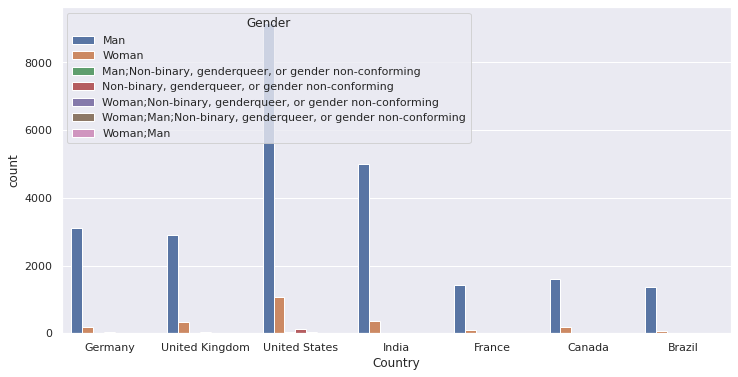

In [24]:
# distribution by gender and country, for the countries with most respondents
# set the figure size
plt.figure(figsize = [12,6])

# adapted clustered bar chart of country and gender
sns.countplot(data=df_most_repres_countries, x='Country', hue='Gender');

#### Observations regarding the distribution by gender:
- with more than 21% of the gender values missing, 71% of the respondents are male.

### Distribution by MainBranch

In [26]:
# distribution by MainBranch professional level
df.MainBranch.value_counts(normalize=True, dropna=False) * 100

I am a developer by profession                                                   73.211709
I am a student who is learning to code                                           12.364065
I am not primarily a developer, but I write code sometimes as part of my work     8.535393
I code primarily as a hobby                                                       3.589767
I used to be a developer by profession, but no longer am                          1.835218
NaN                                                                               0.463846
Name: MainBranch, dtype: float64

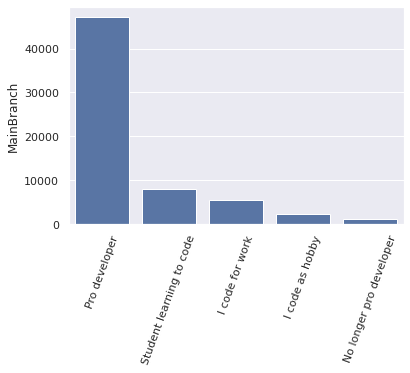

In [27]:
# plot the value counts with their categories
g = sns.barplot(x=df.MainBranch.value_counts().index, y=df.MainBranch.value_counts(), color='b');
# create a list of shorter labels
new_ticks = ['Pro developer', 'Student learning to code', 
             'I code for work', 'I code as hobby', 'No longer pro developer']
# change and rotate the xticks
g.set_xticklabels(new_ticks, rotation=70);

In [28]:
# distribution by Hobbyist in percentages - if developers code as hobby
df.Hobbyist.value_counts(normalize=True, dropna=False) * 100

Yes    78.168195
No     21.761996
NaN     0.069810
Name: Hobbyist, dtype: float64

#### Observations regarding the professional distribution of the respondents:
- there are very few missing values, about 0.4%, in the professional status;
- more than 73% of the respondents are professional developers;
- many developers enjoy coding as a hobby also.

### What type of developers are among the respondents?

In [29]:
# rename the data engineer string in the full dataset
df['DevType'] = df['DevType'].str.replace('Engineer, data', 'Data engineer')

In [30]:
# respondents choose more than one answer as we can see below
DevType_counts = df.DevType.value_counts().reset_index()
DevType_counts.head(4)

,index,DevType
0,"Developer, full-stack",4424
1,"Developer, back-end",3086
2,"Developer, back-end;Developer, front-end;Developer, full-stack",2227
3,"Developer, back-end;Developer, full-stack",1476


In [31]:
# how many combinations are there
DevType_counts.shape[0]

8269

In [32]:
# rename the columns in the results dataframe
DevType_counts.rename(columns = {'index':'devChoice', 'DevType':'count'}, inplace=True)
DevType_counts.head(2)

,devChoice,count
0,"Developer, full-stack",4424
1,"Developer, back-end",3086


In [33]:
# create a list of the individual answers that can be marked by a user
dev_choice = list(DevType_counts.devChoice.str.split(';', expand=True)[0].unique())
print(dev_choice)

['Developer, full-stack', 'Developer, back-end', 'Developer, front-end', 'Developer, mobile', 'Developer, desktop or enterprise applications', 'Developer, embedded applications or devices', 'Data scientist or machine learning specialist', 'Data or business analyst', 'Developer, QA or test', 'Designer', 'Academic researcher', 'Engineering manager', 'Data engineer', 'DevOps specialist', 'System administrator', 'Database administrator', 'Developer, game or graphics', 'Senior executive/VP', 'Scientist', 'Product manager', 'Educator', 'Engineer, site reliability', 'Marketing or sales professional']


In [34]:
# create an adjusted dev_choice list, with no data coders
dev_choice_short = [x for x in dev_choice if not 'Data ' in x]
print(dev_choice_short)

['Developer, full-stack', 'Developer, back-end', 'Developer, front-end', 'Developer, mobile', 'Developer, desktop or enterprise applications', 'Developer, embedded applications or devices', 'Developer, QA or test', 'Designer', 'Academic researcher', 'Engineering manager', 'DevOps specialist', 'System administrator', 'Database administrator', 'Developer, game or graphics', 'Senior executive/VP', 'Scientist', 'Product manager', 'Educator', 'Engineer, site reliability', 'Marketing or sales professional']


In [35]:
# the list of types of developers working with data
data_dev = [x for x in dev_choice if 'Data ' in x]
print(data_dev)

['Data scientist or machine learning specialist', 'Data or business analyst', 'Data engineer']


In [36]:
dev_types = uf.counts_strings(dev_choice,df,'DevType')
dev_types

,DevType,counts
0,"Developer, full-stack",27125
1,"Developer, back-end",27228
2,"Developer, front-end",18296
3,"Developer, mobile",9482
4,"Developer, desktop or enterprise applications",11784
5,"Developer, embedded applications or devices",4750
6,Data scientist or machine learning specialist,3988
7,Data or business analyst,4024
8,"Developer, QA or test",3947
9,Designer,5321


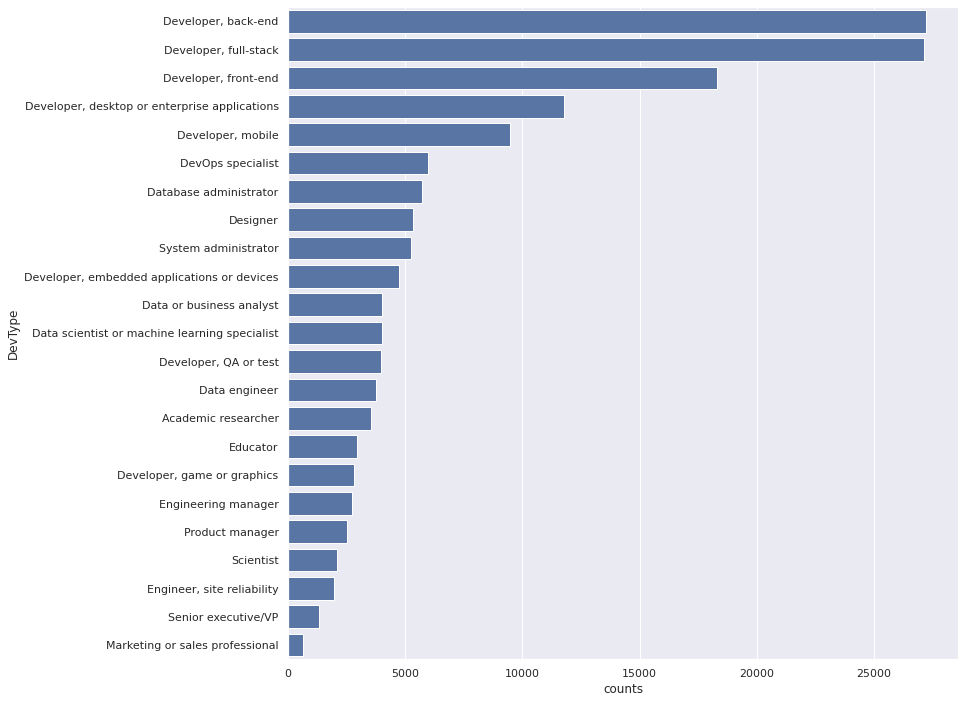

In [37]:
# set the figure size
plt.figure(figsize = [12,12])

# sort values
devs_types = dev_types.sort_values('counts', ascending=False)

# plot the value counts with their categories
sns.barplot(y=devs_types.DevType, x=devs_types.counts, color='b');

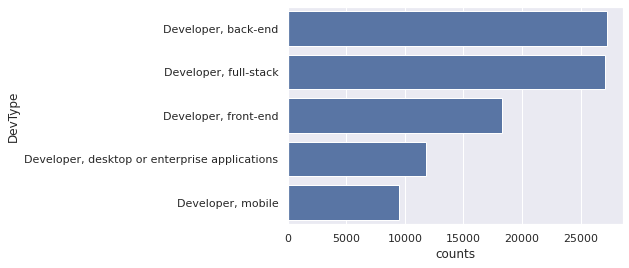

In [38]:
# look at the most popular choices
devs_types = dev_types.sort_values('counts', ascending=False).head(5)

# plot the value counts with their categories
sns.barplot(y=devs_types.DevType, x=devs_types.counts, color='b');

#### Observations regarding the distribution of the developers types:
- most of the respondents identify themselves as back-end, full-stack or front-end developers.


### Distribution of ConvertedComp by Age

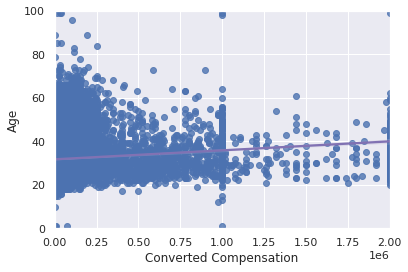

In [39]:
# create a scatterplot 
sns.regplot(x=df['ConvertedComp'], y=df['Age'],
            scatter_kws={'color': 'b'}, line_kws={'color': 'm'})

# create labels
plt.xlabel('Converted Compensation');
plt.ylim(0,100)
plt.ylabel('Age');

### Distribution of ConvertedComp and WorkWeekHrs

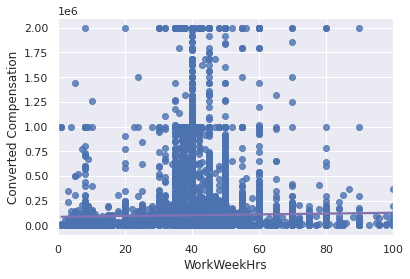

In [40]:
# create a scatterplot 
sns.regplot(y=df['ConvertedComp'], x=df['WorkWeekHrs'],
            scatter_kws={'color': 'b'}, line_kws={'color': 'm'})

# create labels
plt.ylabel('Converted Compensation');
plt.xlim(0,100)
plt.xlabel('WorkWeekHrs');

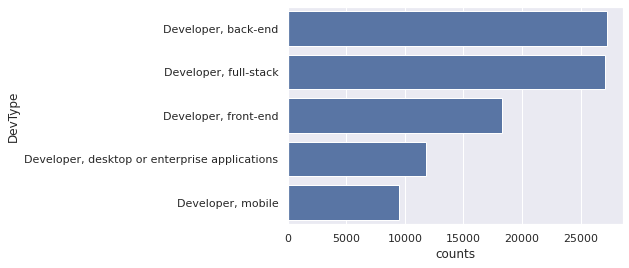

In [41]:
# look at the most popular choices
devs_types = dev_types.sort_values('counts', ascending=False).head(5)

# plot the value counts with their categories
sns.barplot(y=devs_types.DevType, x=devs_types.counts, color='b');

### Distribution of ConvertedComp by EdLevel

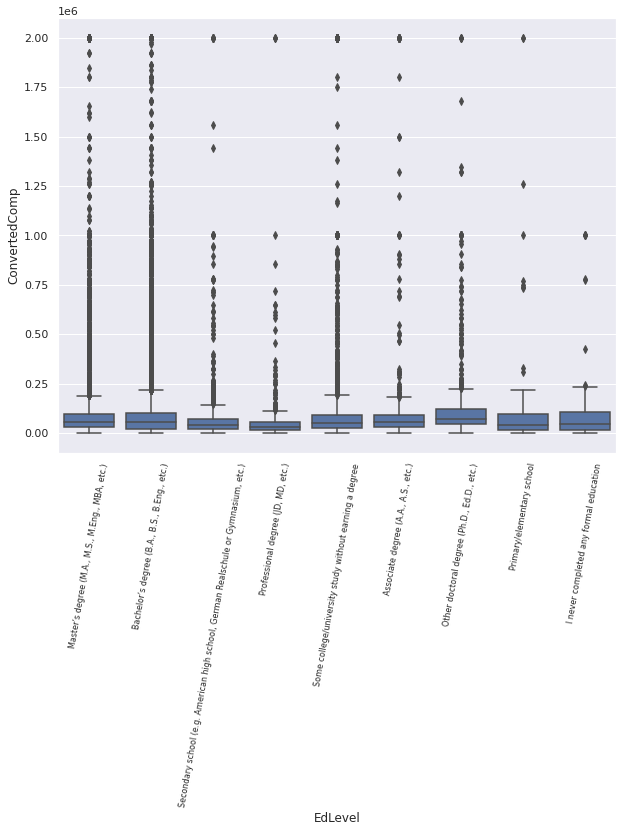

In [42]:
 # resize the figure to accomodate two plots
plt.figure(figsize = [10,8])

# plot on the left: simple scatter
sns.boxplot(x=df.EdLevel, y=df.ConvertedComp, color='b');

# change and rotate the xticks
plt.xticks(size=8, rotation = 80);

#### Observation regarding the ConvertedComp plots
- there are numerous missing values and outliers in each case;
- there does not seem to be a relationship between compensation and age;
- most of the developers work between 30-50 hours a week, but the compensation does not necessarily increase with the work week hours; 
- the compensation is not noticeably related to the education level, many outliers in each class.

### Distribution of JobSat in most represented countries

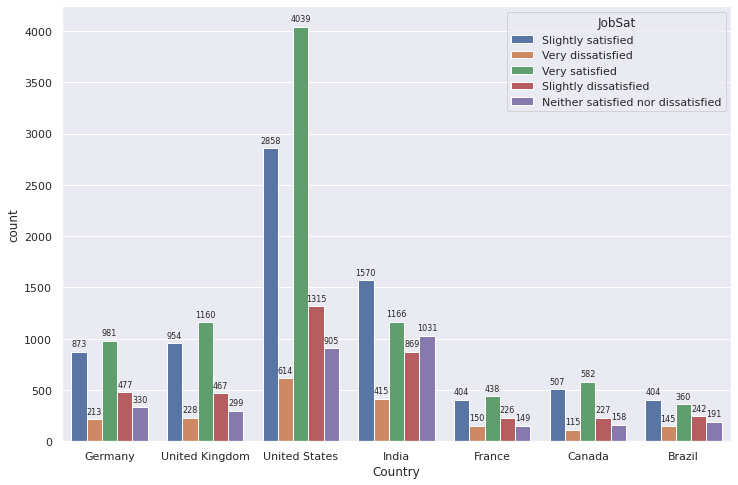

In [43]:
 # resize the figure to accomodate two plots
plt.figure(figsize = [12,8])
g = sns.countplot(data=df_most_repres_countries, x='Country', hue='JobSat');

# annotate the bars
for p in g.patches:
    g.annotate(p.get_height().round(2), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=8,
                   xytext = (0, 8), 
                   textcoords = 'offset points')

### Distribution of ConvertedComp by JobSat

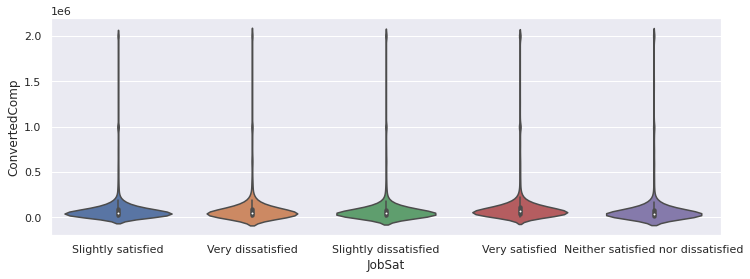

In [44]:
 # resize the figure to accomodate two plots
plt.figure(figsize = [12,4])
sns.violinplot(data=df, x='JobSat', y='ConvertedComp');

#### Observations regarding JobSat plots:
- the developers in US are the happiest with their jobs, whilst those from India seems to be the most neutral in this group;
- the ConvertedComp vs JobSat plot overall shows similar distributions for each level of job satisfaction.

## Data pre-processing

In [45]:
# create a copy of the dataframe
df1 = df.copy()

### Change some columns names

In [46]:
# drop the NEW prefix in some of the columns' names
df1.columns = [col.replace('NEW', '') for col in df1.columns]
df1.columns

Index(['MainBranch', 'Hobbyist', 'Age', 'Age1stCode', 'CompFreq', 'CompTotal',
       'ConvertedComp', 'Country', 'CurrencyDesc', 'CurrencySymbol',
       'DatabaseDesireNextYear', 'DatabaseWorkedWith', 'DevType', 'EdLevel',
       'Employment', 'Ethnicity', 'Gender', 'JobFactors', 'JobSat', 'JobSeek',
       'LanguageDesireNextYear', 'LanguageWorkedWith',
       'MiscTechDesireNextYear', 'MiscTechWorkedWith',
       'CollabToolsDesireNextYear', 'CollabToolsWorkedWith', 'DevOps',
       'DevOpsImpt', 'EdImpt', 'JobHunt', 'JobHuntResearch', 'Learn',
       'OffTopic', 'OnboardGood', 'OtherComms', 'Overtime', 'PurchaseResearch',
       'PurpleLink', 'SOSites', 'Stuck', 'OpSys', 'OrgSize',
       'PlatformDesireNextYear', 'PlatformWorkedWith', 'PurchaseWhat',
       'Sexuality', 'SOAccount', 'SOComm', 'SOPartFreq', 'SOVisitFreq',
       'SurveyEase', 'SurveyLength', 'Trans', 'UndergradMajor',
       'WebframeDesireNextYear', 'WebframeWorkedWith', 'WelcomeChange',
       'WorkWeekHrs', 'Ye

### Create a column to label the developers in data coders and other developers

In [47]:
# use np.where(condition, value if condition is true, value if condition is false)
# create column DevClass, entry data_coder or other_coder, based on DevType contains data or not
df1['DevClass'] = np.where(df1["DevType"].str.contains("Data ", na = False), 'data_coder', 'other_coder')

# check for success
df1.DevClass.value_counts()

other_coder    55735
data_coder      8726
Name: DevClass, dtype: int64

### Change some descriptions into shorter strings

In [48]:
# get the choices for the education level question
edLevel_list = list(df1.EdLevel.unique())
edLevel_list

['Master’s degree (M.A., M.S., M.Eng., MBA, etc.)',
 'Bachelor’s degree (B.A., B.S., B.Eng., etc.)',
 nan,
 'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
 'Professional degree (JD, MD, etc.)',
 'Some college/university study without earning a degree',
 'Associate degree (A.A., A.S., etc.)',
 'Other doctoral degree (Ph.D., Ed.D., etc.)',
 'Primary/elementary school',
 'I never completed any formal education']

In [49]:
# create a dictionary with shorter strings for education levels
new_edLevel = {'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)': 'Master’s degree',
 'Bachelor’s degree (B.A., B.S., B.Eng., etc.)': 'Bachelor’s degree',
 'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)':  'Secondary school',
 'Professional degree (JD, MD, etc.)': 'Professional degree',
 'Some college/university study without earning a degree': 'College study/no degree',
 'Associate degree (A.A., A.S., etc.)' : 'Associate degree',
 'Other doctoral degree (Ph.D., Ed.D., etc.)': 'Other doctoral degree',
 'I never completed any formal education' : 'No formal education'}

In [50]:
# check for success
df1.replace(new_edLevel, inplace=True)
df1.EdLevel.unique()

array(['Master’s degree', 'Bachelor’s degree', nan, 'Secondary school',
       'Professional degree', 'College study/no degree',
       'Associate degree', 'Other doctoral degree',
       'Primary/elementary school', 'No formal education'], dtype=object)

In [51]:
# take a look of the undegraduate major options
df1.UndergradMajor.unique()

array(['Computer science, computer engineering, or software engineering',
       nan, 'Mathematics or statistics',
       'Another engineering discipline (such as civil, electrical, mechanical, etc.)',
       'A humanities discipline (such as literature, history, philosophy, etc.)',
       'A health science (such as nursing, pharmacy, radiology, etc.)',
       'Information systems, information technology, or system administration',
       'Web development or web design',
       'A natural science (such as biology, chemistry, physics, etc.)',
       'Fine arts or performing arts (such as graphic design, music, studio art, etc.)',
       'I never declared a major',
       'A social science (such as anthropology, psychology, political science, etc.)',
       'A business discipline (such as accounting, finance, marketing, etc.)'],
      dtype=object)

In [52]:
# create a dictionary with shorter descriptions for the undegraduate majors
new_UndergradMajor = {'Computer science, computer engineering, or software engineering':
                           'Computer science',
       'Another engineering discipline (such as civil, electrical, mechanical, etc.)':'Engineering other',
       'A humanities discipline (such as literature, history, philosophy, etc.)': 'Humanities',
       'A health science (such as nursing, pharmacy, radiology, etc.)': 'Health science',
       'Information systems, information technology, or system administration' : 'Information system',
       'Web development or web design': 'Web dev/design',
        'Mathematics or statistics': 'Math or stats',
       'A natural science (such as biology, chemistry, physics, etc.)': 'Natural science',
       'Fine arts or performing arts (such as graphic design, music, studio art, etc.)': 'Arts',
       'I never declared a major': 'No major',
       'A social science (such as anthropology, psychology, political science, etc.)': 'Social science',
       'A business discipline (such as accounting, finance, marketing, etc.)': 'Business'}

In [53]:
# check for success
df1.replace(new_UndergradMajor, inplace=True)
df1.UndergradMajor.unique()

array(['Computer science', nan, 'Math or stats', 'Engineering other',
       'Humanities', 'Health science', 'Information system',
       'Web dev/design', 'Natural science', 'Arts', 'No major',
       'Social science', 'Business'], dtype=object)

In [54]:
# replace some strings in the EdImpt column
new_EdImpt = {'Not at all important/not necessary': 'Not important'}
df1.replace(new_EdImpt, inplace=True)
df1.EdImpt.unique()

array(['Fairly important', nan, 'Not important', 'Very important',
       'Somewhat important', 'Critically important'], dtype=object)

### Drop duplicates 

In [55]:
# drop duplicates if any
df1.drop_duplicates()

# check new datafrae size
df1.shape

(64461, 61)

## Save the processed dataframe to a file

In [56]:
# save a copy of the prepared dataframe
df1.to_csv(mypath + '/data/survey20_updated.csv')